<a href="https://colab.research.google.com/github/kotekjedi/GANs-ITMO-2022-Masters/blob/main/Assignment%201/1_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR10 dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

In [2]:
import torchvision
from torch.utils.data import DataLoader

### Define parameters & data loading 

In [3]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

#Check device
print("device used: ", device)

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

device used:  cpu


Label:  5


(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 100 BarContainer objects>)

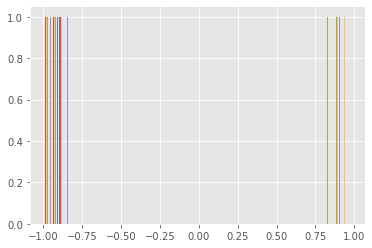

In [4]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [5]:
# denormalization image from range (-1)-1 to range 0-1 to display it
image_W = 28
image_H = 28
image_C = 1


def denorm(x):
    batch_size_ = x.size(0)
    x = x.view(batch_size_ , -1)
    x -= x.min(1, keepdim=True)[0]
    x /= x.max(1, keepdim=True)[0]
    x = x.view(batch_size_, image_C, image_H, image_W)
    return x

img = denorm(img.unsqueeze(0)).squeeze(0)

#Check correct changes
print("Min: ", img.min().item())
print("Max: ", img.max().item())

    

Min:  0.0
Max:  1.0


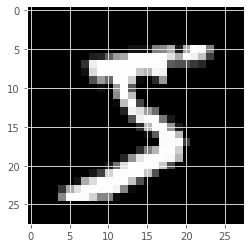

In [6]:
# show image sample with matplotlib

# Входное изображение представляет собой тензор (C, H, W)
# Чтобы построить его с помощью matplotlib, нам нужно изменить его на (H, W, C)
# **color необходим для передачи цвета в функцию imshow

def plot_torch_image(img, **color):
    plt.imshow(img.permute(1, 2, 0) , **color)
    
plot_torch_image(img,cmap='gray')



In [7]:
# define the dataloader

data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.l1 = nn.Linear(latent_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.l2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is image_size
        self.l3 = nn.Linear(hidden_size, image_size)
    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        
        x = self.l1(x)
        x = nn.ReLU()(x)
        x = self.l2(x)
        x = nn.ReLU()(x)
        x = self.l3(x)
        x = nn.Tanh()(x) 
        
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.l1 = nn.Linear(image_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.l2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is 1
        self.l3 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        
        x = self.l1(x)
        x = nn.ReLU()(x)
        x = self.l2(x)
        x = nn.ReLU()(x)
        x = self.l3(x)
        x = nn.Sigmoid()(x) 
        
        return x

### Create the Generator and Discriminator

In [9]:
# create new Generator model
# G = Generator...

G = Generator(latent_size,image_size, hidden_size)

# create new Discriminator model
# D = Discriminator...

D = Discriminator(image_size, hidden_size)


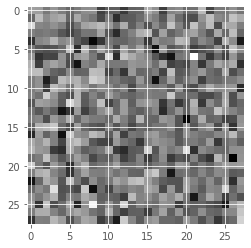

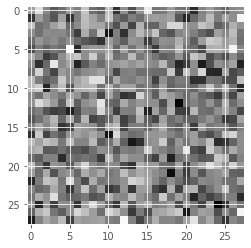

In [10]:
# show the output of model
y = G(torch.randn(2, latent_size))

for img in y:
    img= img.reshape(image_C,image_H,image_W)
    plt.figure()
    plot_torch_image(img.detach(),cmap='gray')



In [11]:
# define the criterion is nn.BCELoss()

loss_fn = nn.BCELoss()

## Define the optimizer for generator and discrimator

G_opt = torch.optim.Adam(G.parameters(), lr=LR)
D_opt = torch.optim.Adam(D.parameters(), lr=LR)


Discriminator Training

In [12]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    
    G_opt.zero_grad()
    D_opt.zero_grad()
    
    

def train_discriminator(D_model, G_model, images, device=device, batch_size=batch_size, latent_size=latent_size):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    outputs = D_model(images)
    
    # Loss for real images
    
    loss_r = loss_fn(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)
    loss_f = loss_fn(outputs, fake_labels)
    fake_score = outputs 
    # Sum losses
    d_loss = loss_r + loss_f
    # Adjust the parameters using backprop
    d_loss.backward()
    # Compute gradients
    D_opt.step()
    # Reset gradients
    reset_grad()
    
    return d_loss, real_score, fake_score

Generator Training

In [13]:
def train_generator(G_model, device=device, batch_size=batch_size, latent_size=latent_size):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    
    
    

    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = loss_fn(outputs, labels)
    
    # Backprop and optimize
    g_loss.backward()
    G_opt.step()
    
    # Reset gradients
    reset_grad()
    
    return g_loss, fake_images

### Start the training proccess

In [14]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index, sample_dir=sample_dir, device=device, batch_size=batch_size, latent_size=latent_size):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [15]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)
        # Train the generator
        g_loss, fake_images = train_generator(G)
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.2094, g_loss: 2.3649, D(x): 0.95, D(G(z)): 0.15
Epoch [0/300], Step [400/600], d_loss: 0.2165, g_loss: 4.2024, D(x): 0.91, D(G(z)): 0.08
Epoch [0/300], Step [600/600], d_loss: 0.0210, g_loss: 5.0765, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3356, g_loss: 2.3307, D(x): 0.89, D(G(z)): 0.17
Epoch [1/300], Step [400/600], d_loss: 1.5303, g_loss: 2.6021, D(x): 0.59, D(G(z)): 0.37
Epoch [1/300], Step [600/600], d_loss: 0.3865, g_loss: 3.2589, D(x): 0.88, D(G(z)): 0.19
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 2.3382, g_loss: 1.2329, D(x): 0.51, D(G(z)): 0.63
Epoch [2/300], Step [400/600], d_loss: 0.6588, g_loss: 2.1203, D(x): 0.78, D(G(z)): 0.22
Epoch [2/300], Step [600/600], d_loss: 1.1450, g_loss: 2.1465, D(x): 0.69, D(G(z)): 0.35
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2754, g_loss: 2.3809, D(x): 0.91, D(G(z)): 0.15
Epoch [3/300], Step [400/6

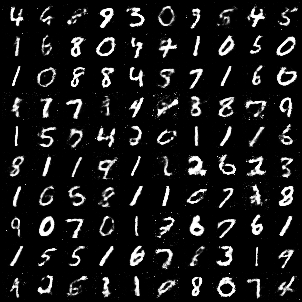

In [17]:
# show output after epochs training
from IPython.display import Image
Image(os.path.join(sample_dir, "fake_images-0225.png"))

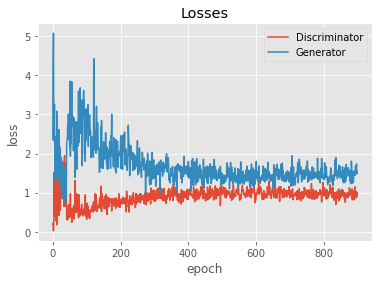

In [18]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

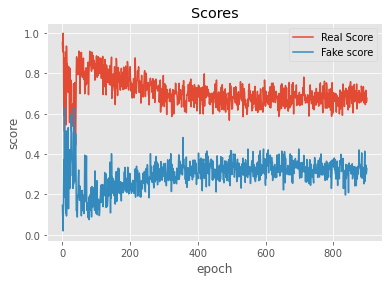

In [19]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
from PIL import Image 
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from datetime import datetime
import random
import os

In [4]:
%matplotlib inline
plt.style.use("ggplot")


class CFG:
    #change batch_size
    batch_size = 64
    num_epochs = 300
    workers = 4
    seed = 2021
    image_W = 64
    image_H = 64
    image_C = 3 ## number chanels  ngf = 64 #Size of feature maps in generator
    download = True
    dataroot = "data"
    nz = 100 #latent random input vector
    ngf = 64 #Size of feature maps in generator
    ndf = 64 #Size of feature maps in discriminator
    dlr = 0.0002
    glr = 0.0002
    lrelu_slope = 0.02
    device = 'cuda'  
    sample_dir = "./images_v4/"
    
if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)
dataset = torchvision.datasets.CIFAR10(root=CFG.dataroot, download=CFG.download,
                               transform=transforms.Compose([
                                  transforms.Resize([CFG.image_H, CFG.image_W]),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))


Files already downloaded and verified


In [5]:
torch.manual_seed(CFG.seed)
random.seed(CFG.seed)
np.random.seed(CFG.seed)

In [6]:
dataset[0][0].shape

torch.Size([3, 64, 64])

Label:  6


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.8745098 , -0.8112418 , -0.74797386, -0.68470585, -0.6214379 ,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986], dtype=float32),
 <a list of 300 BarContainer objects>)

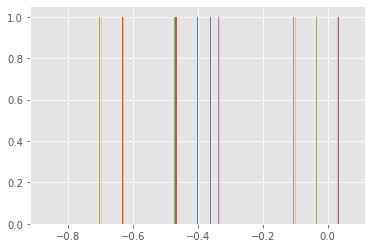

In [7]:
img, label = dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [8]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def unnomalization(x):
    batch_size_ = x.size(0)
    x = x.view(batch_size_ , -1)
    x -= x.min(1, keepdim=True)[0]
    x /= x.max(1, keepdim=True)[0]
    x = x.view(batch_size_, CFG.image_C, CFG.image_H, CFG.image_W)
    return x


img = unnomalization(img.unsqueeze(0)).squeeze(0) # The functions expects first dim to be batch_size
print("Min: ", img.min().item())
print("Max: ", img.max().item())

Min:  0.0
Max:  1.0


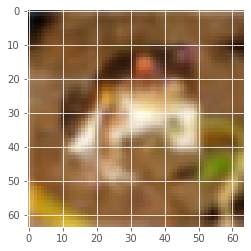

In [9]:
# show image sample with matplotlib
def plot_torch_image(img, **kwargs):
    plt.imshow(img.permute(1, 2, 0) , **kwargs)  
plot_torch_image(img)

In [10]:
# Create the dataloader
data_loader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=True, drop_last=True)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
class Generator(nn.Module):
    def __init__(self, nc, h, w, nz, ngf):
        #ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu 
        #ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding 
        super(Generator, self).__init__()
        self.nc = nc
        self.h = h
        self.w = w
        self.ngf = ngf
        
        self.linear = nn.Linear(nz, nc * h * w)
        self.conv1 = nn.ConvTranspose2d(in_channels=nc, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(ngf)
        self.conv2 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(ngf)
        self.conv3 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(ngf)
        self.conv4 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch4 = nn.BatchNorm2d(ngf) 
        self.conv5 = nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=(3,3), stride=1, padding=1)
        # init weights
        self.linear.weight.data.normal_(0.0, 0.02) 
        self.conv1.weight.data.normal_(0.0, 0.02)
        self.conv2.weight.data.normal_(0.0, 0.02)
        self.conv3.weight.data.normal_(0.0, 0.02)
        self.conv4.weight.data.normal_(0.0, 0.02)
        self.conv5.weight.data.normal_(0.0, 0.02)
    def forward(self, x):
        bs= x.shape[0]
        x = self.linear(x)
        x = x.view(bs, self.nc, self.h, self.w)
        x = self.conv1(x)
        x = self.batch1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = nn.ReLU()(x)     
        x = self.conv3(x)
        x = self.batch3(x)
        x = nn.ReLU()(x) 
        x = self.conv4(x)
        x = self.batch4(x)
        x = nn.ReLU()(x)
        x = self.conv5(x)
        return torch.tanh(x)


class Discriminator(nn.Module):
    def __init__(self, nc, h, w, ndf):
    #conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        self.l_relu1 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv2 = nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(ndf)
        self.l_relu2 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv3 = nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(ndf)
        self.l_relu3 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv4 = nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(ndf)
        self.l_relu4 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv5 = nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1)
        
        self.linear = nn.Linear(262144, 1)
        # init weights
        self.conv1.weight.data.normal_(0.0, 0.02)
        self.conv2.weight.data.normal_(0.0, 0.02)
        self.conv3.weight.data.normal_(0.0, 0.02)
        self.conv4.weight.data.normal_(0.0, 0.02)
        self.conv5.weight.data.normal_(0.0, 0.02)
        self.linear.weight.data.normal_(0.0, 0.02)
    def forward(self, x):
        x = self.conv1(x)
        x = self.l_relu1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.l_relu2(x)
        x = self.conv3(x)
        x = self.bn2(x) 
        x = self.l_relu3(x)
        x = self.conv4(x)
        x = self.bn3(x) 
        x = self.l_relu4(x)
        x = self.conv5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return nn.Sigmoid()(x)


In [12]:
# create new Generator model
G = Generator(CFG.image_C, CFG.image_H, CFG.image_W, CFG.nz, CFG.ngf)
# create new Discriminator model
D = Discriminator(CFG.image_C, CFG.image_H, CFG.image_W, CFG.ndf)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


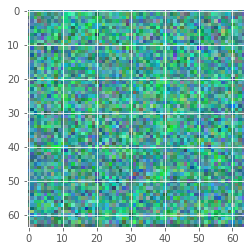

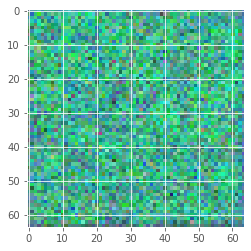

In [13]:
# show the output of model 
y = G(torch.randn(2, CFG.nz))
with torch.no_grad():
    for img in y:
        print(img.size())
        img = unnomalization(img.unsqueeze(0)).squeeze(0)
        plt.figure()
        plot_torch_image(img.detach())

In [14]:
# define the criterion is nn.BCELoss()
loss_fn = nn.BCELoss()
## Define the optimizer for generator and discrimator
G_optim = torch.optim.Adam(G.parameters(),betas=(0.5, 0.999),  lr=CFG.glr)
D_optim = torch.optim.Adam(D.parameters(),betas=(0.5, 0.999),  lr=CFG.dlr)

In [15]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optim.zero_grad()
    D_optim.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = (torch.ones(CFG.batch_size, 1) * 0.9).to(CFG.device)
    fake_labels = (torch.zeros(CFG.batch_size, 1) + 0.1).to(CFG.device)
    
    outputs = D(images)
    # Loss for real images
    loss_r = loss_fn(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz).to(CFG.device)
    fake_images = G(z)
    outputs = D(fake_images)
    loss_f = loss_fn(outputs, fake_labels)
    fake_score = outputs
    # Sum losses
    d_loss = loss_r + loss_f
    # Adjust the parameters using backprop
    d_loss.backward()
    # Compute gradients
    D_optim.step()
    # Reset gradients
    reset_grad()

    return d_loss, real_score, fake_score

In [16]:
def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz))).to(CFG.device)
    fake_images = G(z)
    labels = (torch.ones(CFG.batch_size, 1) * 0.9).to(CFG.device)
    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = loss_fn(outputs, labels)
    # Backprop and optimize
    g_loss.backward()
    G_optim.step()
    # Reset gradients
    reset_grad()
    return g_loss, fake_images

## Start the training proccess

In [17]:
def save_fake_images(index):
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz))).to(CFG.device)
    fake_images = G(sample_vectors)
#     fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(unnomalization(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=8)

In [18]:
%%time
print(" -- Training started")
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(CFG.device)
D.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
#         images = images.reshape(CFG.batch_size, -1).to(CFG.device)
        images = images.to(CFG.device)
        # Train the discriminator  once
        d_loss, real_score, fake_score = train_discriminator(images)
        #Train the generator
        g_loss, fake_images = train_generator()
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    CFG.num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images(epoch+1)

 -- Training started
Epoch [0/300], Step [200/781], d_loss: 2.0698, g_loss: 0.3842, D(x): 0.27, D(G(z)): 0.01
Epoch [0/300], Step [400/781], d_loss: 0.7542, g_loss: 2.3600, D(x): 0.80, D(G(z)): 0.08
Epoch [0/300], Step [600/781], d_loss: 0.7675, g_loss: 2.5625, D(x): 0.91, D(G(z)): 0.22
Saving fake_images-0001.png
Epoch [1/300], Step [200/781], d_loss: 8.5963, g_loss: 2.9591, D(x): 0.97, D(G(z)): 0.55
Epoch [1/300], Step [400/781], d_loss: 0.7948, g_loss: 2.2416, D(x): 0.83, D(G(z)): 0.23
Epoch [1/300], Step [600/781], d_loss: 0.9172, g_loss: 3.0010, D(x): 0.75, D(G(z)): 0.29
Saving fake_images-0002.png
Epoch [2/300], Step [200/781], d_loss: 1.2764, g_loss: 0.9718, D(x): 0.48, D(G(z)): 0.05
Epoch [2/300], Step [400/781], d_loss: 0.8002, g_loss: 1.6795, D(x): 0.78, D(G(z)): 0.08
Epoch [2/300], Step [600/781], d_loss: 0.9125, g_loss: 1.9317, D(x): 0.68, D(G(z)): 0.08
Saving fake_images-0003.png
Epoch [3/300], Step [200/781], d_loss: 0.8236, g_loss: 2.3232, D(x): 0.78, D(G(z)): 0.22
Epoch

KeyboardInterrupt: 

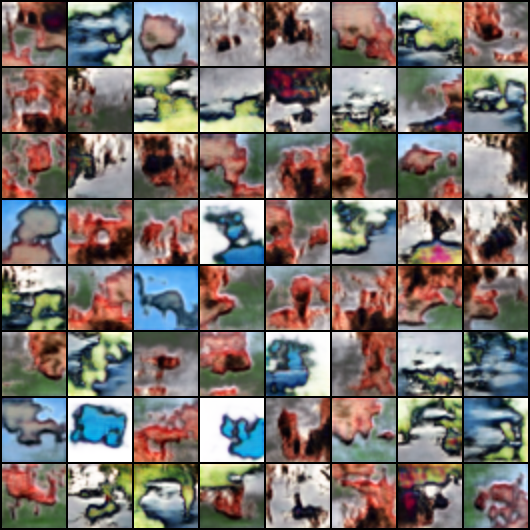

In [19]:
from IPython.display import Image
Image(os.path.join(CFG.sample_dir, 'fake_images-0015.png'))

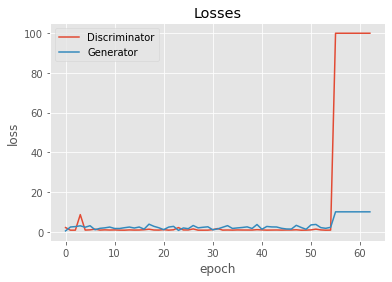

In [20]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

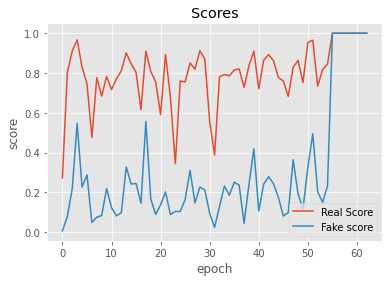

In [21]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');